In [66]:
import h5py, os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
hf = h5py.File('data/channel_x1_256_y1_512_z1_256_step2.h5', 'r')
hf_pressure = h5py.File('data/channel_x1_256_y1_512_z1_256_step2_pressure.h5', 'r')

In [3]:
vels = hf.get('Velocity_0001')
xs = hf.get('xcoor')
ys = hf.get('ycoor')
zs = hf.get('zcoor')
ps = hf_pressure.get('Pressure_0001')

In [4]:
ys = ys[1:]
vels = vels[:, 1:, :, :]
ps = ps[:, 1:, ...]

In [5]:
ys.shape, ps.shape

((255,), (128, 255, 128, 1))

In [6]:
us = vels[..., 0]
vs = vels[..., 1]
ws = vels[..., 2]

In [7]:
# flatten the velocity as we
us_flattened = us.flatten()

In [8]:
# gather all the positions
yv, xv, zv = np.meshgrid(ys, xs, zs) 

In [9]:
# flatten a give slice of data
slice_num = 0
xv_flattened_2d = np.expand_dims(xv[:,:,slice_num].flatten(), axis=1)
yv_flattened_2d = np.expand_dims(yv[:,:,slice_num].flatten(), axis=1)
coords_flattened_2d = np.concatenate((yv_flattened_2d, xv_flattened_2d), axis=1)
print(coords_flattened_2d.shape)

(32640, 2)


In [22]:
vs.shape[-1]

128

In [10]:
us2d = us[:, :, slice_num]
us2d_flattened = np.expand_dims(us2d.flatten(), axis=1)
vs2d = vs[:, :, slice_num]
vs2d_flattened = np.expand_dims(vs2d.flatten(), axis=1)
ps2d = ps[:, :, slice_num]
ps2d_flattened = np.expand_dims(ps2d.flatten(), axis=1)
ws2d = ws[:, :, slice_num]
ws2d_flattened = np.expand_dims(ws2d.flatten(), axis=1)

In [11]:
# create a regular grid to map the dataset values to a 2D grid
grid_x = np.linspace(xv.min(), xv.max(), 256)
grid_y = np.linspace(yv.min(), yv.max(), 256)

In [12]:
# get the positions at which we want to evaluate the flow value - flatten for griddata function
yeval, xeval = np.meshgrid(grid_y, grid_x)
xeval_flattened = np.expand_dims(xeval.flatten(), axis=1)
yeval_flattened = np.expand_dims(yeval.flatten(), axis=1)

In [13]:
# interpolate the values at the regular grid points
us_interp = griddata(coords_flattened_2d, us2d_flattened, (yeval, xeval), method='linear', fill_value=0)
vs_interp = griddata(coords_flattened_2d, vs2d_flattened, (yeval, xeval), method='linear', fill_value=0)
ps_interp = griddata(coords_flattened_2d, ps2d_flattened, (yeval, xeval), method='linear', fill_value=0)
# ws_interp = griddata(coords_flattened_2d, ws2d_flattened, (yeval, xeval), method='linear', fill_value=0)

In [14]:
def interp_slice(slice_num = 0):
    us2d = us[:, :, slice_num]
    us2d_flattened = np.expand_dims(us2d.flatten(), axis=1)
    vs2d = vs[:, :, slice_num]
    vs2d_flattened = np.expand_dims(vs2d.flatten(), axis=1)
    ps2d = ps[:, :, slice_num]
    ps2d_flattened = np.expand_dims(ps2d.flatten(), axis=1)
    us_interp = griddata(coords_flattened_2d, us2d_flattened, (yeval, xeval), method='linear', fill_value=0)
    vs_interp = griddata(coords_flattened_2d, vs2d_flattened, (yeval, xeval), method='linear', fill_value=0)
    ps_interp = griddata(coords_flattened_2d, ps2d_flattened, (yeval, xeval), method='linear', fill_value=0)
    return us_interp, vs_interp, ps_interp

In [15]:
xeval =  np.expand_dims(np.transpose(xeval, axes=(1, 0)), axis=-1)
yeval =  np.expand_dims(np.transpose(yeval, axes=(1, 0)), axis=-1)
us_interp =  np.transpose(us_interp, axes=(1, 0, 2))
vs_interp =  np.transpose(vs_interp, axes=(1, 0, 2))
ps_interp =  np.transpose(ps_interp, axes=(1, 0, 2))

In [16]:
us_interp.shape

(256, 256, 1)

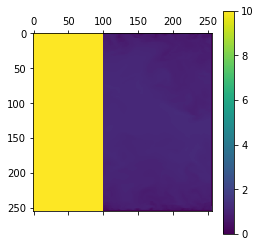

In [148]:
plt.matshow(us_interp[..., 0])
plt.colorbar()

In [146]:
us_interp[..., 0].shape

(256, 256)

In [147]:
us_interp[:, :100, 0] = 10

In [26]:
flow = np.concatenate((xeval, yeval, us_interp, vs_interp, ps_interp), axis=-1)

In [27]:
flow_padded = np.zeros((300, 300, 5))
flow_padded[22:-22, 22:-22, :] = flow

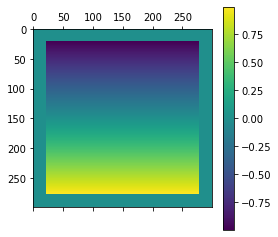

In [28]:
plt.matshow(flow_padded[...,1])
plt.colorbar()

256

In [67]:
class DatasetFromFlow():

    def __init__(self, flow_filename, pressure_filename):
        os.makedirs('data/' + flow_filename.split('/')[1].split('.')[0], exist_ok=True)
        
        hf = h5py.File(flow_filename, 'r')
        hf_pressure = h5py.File(pressure_filename, 'r')

        vels = hf.get('Velocity_0001')[:, 1:, :, :]
        self.us = vels[..., 0]
        self.vs = vels[..., 1]
        self.xs = hf.get('xcoor')
        self.ys = hf.get('ycoor')[1:]
        self.zs = hf.get('zcoor')
        self.ps = hf_pressure.get('Pressure_0001')[:, 1:, :, :]

        # gather all the positions
        yv, xv = np.meshgrid(ys, xs) 
        
        # flatten a give slice of data
        xv_flattened_2d = np.expand_dims(xv[:,:].flatten(), axis=1)
        yv_flattened_2d = np.expand_dims(yv[:,:].flatten(), axis=1)
        self.coords_flattened_2d = np.concatenate((yv_flattened_2d, xv_flattened_2d), axis=1)

        # create a regular grid to map the dataset values to a 2D grid
        self.grid_x = np.linspace(xv.min(), xv.max(), 256)
        self.grid_y = np.linspace(yv.min(), yv.max(), 256)

        # get the positions at which we want to evaluate the flow value - flatten for griddata function
        self.yeval, self.xeval = np.meshgrid(self.grid_y, self.grid_x)
        # self.xeval_flattened = np.expand_dims(xeval.flatten(), axis=1)
        # self.yeval_flattened = np.expand_dims(yeval.flatten(), axis=1)

    def get_slice(self, idx):
        us2d_flattened = np.expand_dims(self.us[:, :, idx].flatten(), axis=1)
        vs2d_flattened = np.expand_dims(self.vs[:, :, idx].flatten(), axis=1)
        ps2d_flattened = np.expand_dims(self.ps[:, :, idx].flatten(), axis=1)

        # interpolate the values at the regular grid points
        us_interp = griddata(self.coords_flattened_2d, us2d_flattened, (self.yeval, self.xeval), method='linear', fill_value=0)
        vs_interp = griddata(self.coords_flattened_2d, vs2d_flattened, (self.yeval, self.xeval), method='linear', fill_value=0)
        ps_interp = griddata(self.coords_flattened_2d, ps2d_flattened, (self.yeval, self.xeval), method='linear', fill_value=0)

        return us_interp, vs_interp, ps_interp

    def prepare_data(self, idx):
        us_interp, vs_interp, ps_interp =  self.get_slice(idx)
        
        xeval =  np.expand_dims(np.transpose(self.xeval, axes=(1, 0)), axis=-1)
        yeval =  np.expand_dims(np.transpose(self.yeval, axes=(1, 0)), axis=-1)
        us_interp =  np.transpose(us_interp, axes=(1, 0, 2))
        vs_interp =  np.transpose(vs_interp, axes=(1, 0, 2))
        ps_interp =  np.transpose(ps_interp, axes=(1, 0, 2))

        '''self.xeval = np.concatenate()...'''
        '''self.yeval = np.concatenate()...'''
        '''self.us_interp = np.concatenate()...'''
        '''self.vs_interp = np.concatenate()...'''
        '''self.ps_interp = np.concatenate()...'''

        return xeval, yeval, us_interp, vs_interp, ps_interp

    def create_dataset(self):

        all_xs = np.zeros((self.us.shape[-1], len(self.grid_x), len(self.grid_y)))
        all_ys = np.zeros((self.us.shape[-1], len(self.grid_x), len(self.grid_y)))
        all_us = np.zeros((self.us.shape[-1], len(self.grid_x), len(self.grid_y)))
        all_vs = np.zeros((self.us.shape[-1], len(self.grid_x), len(self.grid_y)))
        all_ps = np.zeros((self.us.shape[-1], len(self.grid_x), len(self.grid_y)))

        for i in tqdm(range(len(all_xs))):
            xeval, yeval, us_interp, vs_interp, ps_interp = self.prepare_data(i)
            all_xs[i] = xeval[..., 0]
            all_ys[i] = yeval[..., 0]
            all_us[i] = us_interp[..., 0]
            all_vs[i] = vs_interp[..., 0]
            all_ps[i] = ps_interp[..., 0]

        np.save('data/channel_x1_256_y1_512_z1_256_step2/xs.npy', all_xs)
        np.save('data/channel_x1_256_y1_512_z1_256_step2/ys.npy', all_ys)
        np.save('data/channel_x1_256_y1_512_z1_256_step2/us.npy', all_us)
        np.save('data/channel_x1_256_y1_512_z1_256_step2/vs.npy', all_vs)
        np.save('data/channel_x1_256_y1_512_z1_256_step2/ps.npy', all_ps)

        return all_xs, all_ys, all_us, all_vs, all_ps
        


In [68]:
D = DatasetFromFlow('data/channel_x1_256_y1_512_z1_256_step2.h5', 'data/channel_x1_256_y1_512_z1_256_step2_pressure.h5')

In [69]:
all_xs, all_ys, all_us, all_vs, all_ps = D.create_dataset()

100%|██████████| 128/128 [03:28<00:00,  1.63s/it]


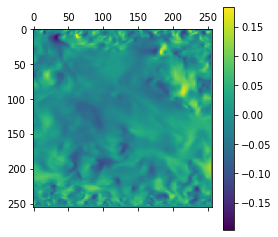

In [99]:
plt.matshow(all_vs[1])
plt.colorbar()

In [29]:
# xv, yv, zv = np.meshgrid(xs, ys, zs) #, indexing="xy")
# gather all the positions
# yv, xv, zv = np.meshgrid(ys, xs, zs) 
# flatten and concatenate the coordinates for future use
# xv_flattened = np.expand_dims(xv.flatten(), axis=1)
# yv_flattened = np.expand_dims(yv.flatten(), axis=1)
# zv_flattened = np.expand_dims(zv.flatten(), axis=1)
# coords_flattened = np.concatenate((yv_flattened, xv_flattened, zv_flattened), axis=1)
# print(coords_flattened.shape)

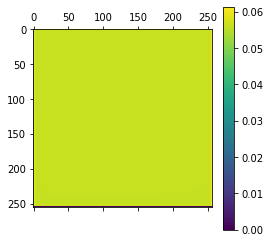

In [149]:
r = np.load('recon12.npy')
plt.matshow(r)
plt.colorbar()